# ML 3-class Classification  (DR3)

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a24c632e0>

MLfit applied to 4FGL-DR3 

SKlearn specifications: 
* features: ('log_var', 'log_fpeak', 'log_epeak', 'd')
* targets: {'pulsar': ('psr', 'msp'), 'bll': ('bll',), 'fsrq': ('fsrq',)}
* model: SVC(C=1, gamma=2)
        

## Feature distributions 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a24437d30>
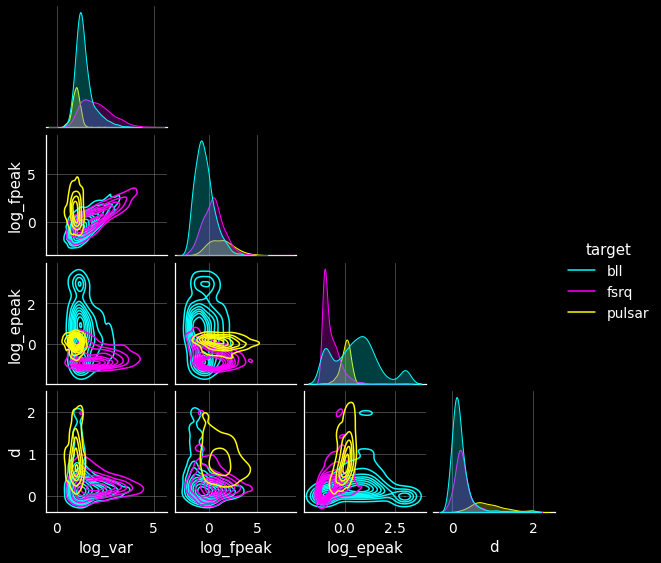

## Train then apply prediction 

### The confusion matrix

prediction,bll,fsrq,pulsar
associations,,,
bll,1253,100,3
fsrq,146,618,7
pulsar,11,2,277


purity=0.97, efficiency=0.96

### All predictions

prediction,bll,fsrq,pulsar
association,,,
bll,1253,100,3
fsrq,146,618,7
psr,3,0,140
msp,8,2,137
glc,7,3,24
bcu,1056,402,96
spp,23,12,66
other,62,38,32
unid,917,347,915


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a2090e740>
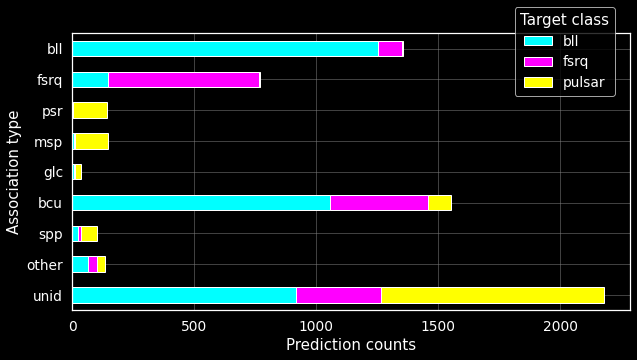

#### Write summary file

File `files/dr3_3_class_classification.csv` exists--not overwriting.


In [1]:
%run pylib/ml_fit dr3  show dark
self=doc(3,2)

## Compare $E_p$ vs $d$ for training and unid prediction

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a206f8310>
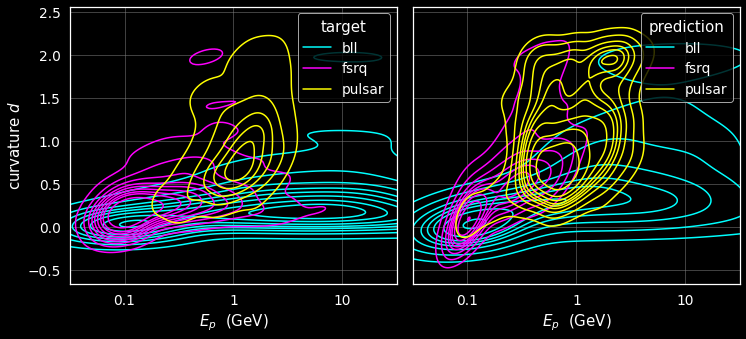

In [2]:
show(f"""## Compare $E_p$ vs $d$ for training and unid prediction""")
show_fig(self.ep_vs_d)

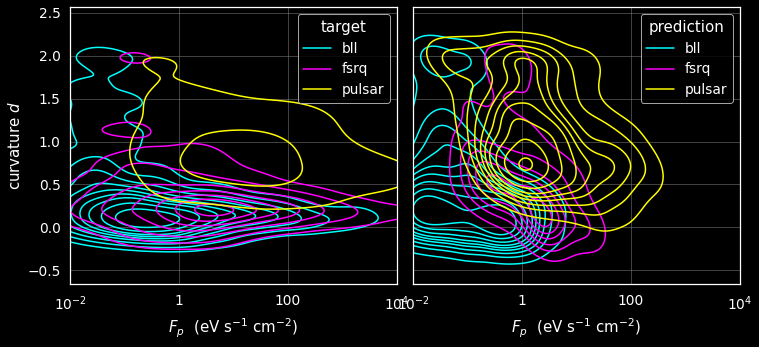

In [3]:
    def fp_vs_d(self, df=None):
        from pylib.tools import fpeak_kw
        if df is None: df=self.df
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12, 5),sharex=True,sharey=True,
                                    gridspec_kw=dict(wspace=0.05))
        kw = dict( x='log_fpeak', y='d',  palette=self.palette[:len(self.targets)],
                  hue_order=self.target_names)
        
        sns.kdeplot(df,ax=ax1, hue=self.target_field, **kw)
        sns.kdeplot(df.query('association=="unid"'),ax=ax2, hue='prediction',**kw)

        ax1.set(**fpeak_kw(),ylabel='curvature $d$', xlim=(-1.5,1.5)); ax2.set(**fpeak_kw())
        return fig
    fp_vs_d(self);

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a2044a2f0>
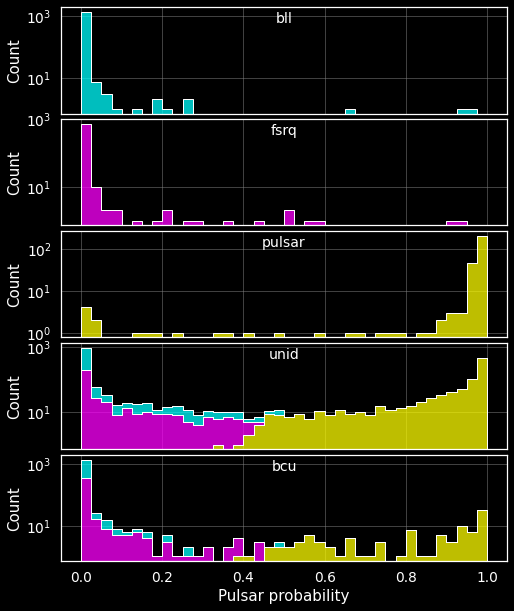

In [4]:
show_fig(self.pulsar_prob_hists, )

In [5]:
probs= self.predict_prob(query=None)
df = pd.concat([self.df, probs], axis=1)
d = {}
for non_target in ['unid','bcu', 'bll', 'fsrq', 'msp', 'psr']:
    unid = df.query(f'association=="{non_target}"').copy()
    d[non_target] = {'Total'     : len(unid),
         'predicted pulsar' : len(unid.query('prediction=="pulsar"')),
         'Likely blazar'    : len(unid.query('p_pulsar<0.15')),
         'Mystery'          : len(unid.query('0.95>p_pulsar>0.15')),
         'Mostly pulsars'   : len(unid.query('p_pulsar>0.95')),
        }
show(pd.DataFrame(d))

,unid,bcu,bll,fsrq,msp,psr
Total,2179,1554,1356,771,147,143
predicted pulsar,915,96,3,7,137,140
Likely blazar,1132,1431,1348,758,4,3
Mystery,468,86,7,13,17,6
Mostly pulsars,579,37,1,0,126,134


<Axes: xlabel='log_epeak', ylabel='d'>

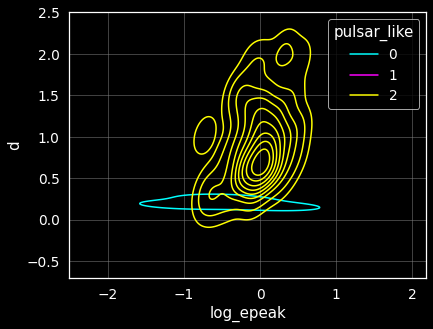

In [6]:
def pulsar_like(p):
    if p < 0.1: return 0
    if p < 0.95: return 1
    return 2
unid['pulsar_like'] = unid.p_pulsar.apply(pulsar_like)
sns.kdeplot(unid, x='log_epeak', y='d', hue='pulsar_like', palette=self.palette)


### Mystery

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a207fe560>
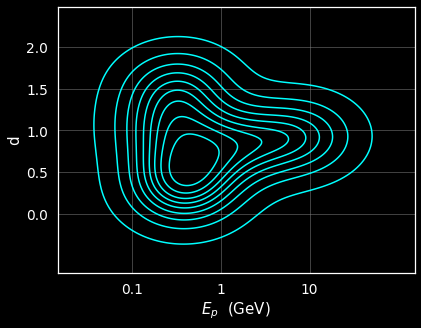

In [7]:
ax=sns.kdeplot(unid.query('0.95>p_pulsar>0.1'), color='cyan', x='log_epeak', y='d');
ax.set(**epeak_kw(), yticks=np.arange(0,2.1,0.5));
show(f"""### Mystery""")
show(ax.figure)

### Featues for unid's

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f7a0bfa91e0>
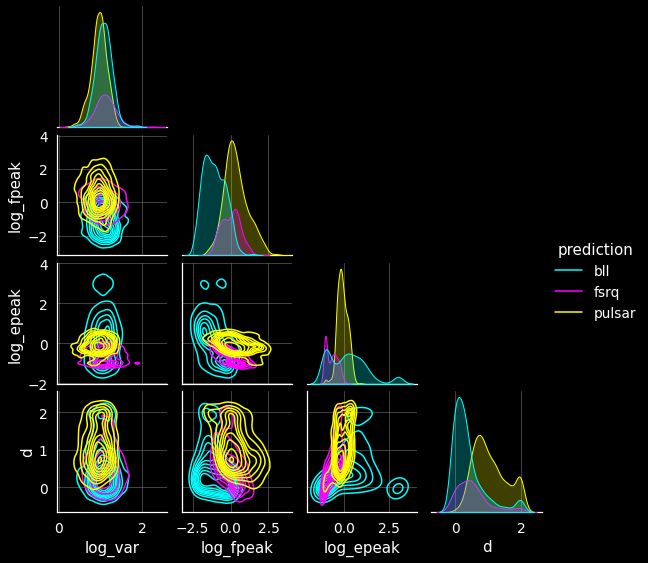

In [8]:
show("""### Featues for unid's""")
show_fig(self.pairplot, query='association=="unid"', hue='prediction');

prediction,bll,fsrq,pulsar
0,1056,402,96


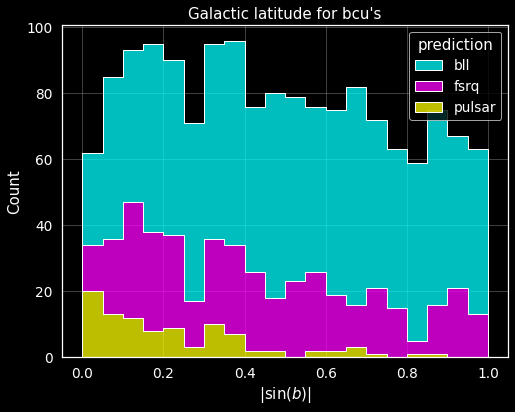

In [23]:
bcu = df.query('association=="bcu"')
show(bcu.groupby('prediction').size())
z = np.abs( np.abs(np.sin(np.radians(bcu.glat) )))
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(bcu, ax=ax, x=z, hue='prediction', palette=self.palette, 
             bins=np.arange(0,1.01,0.05), element='step', multiple='stack');
ax.set(xlabel=r'$|\sin(b)|$', title="Galactic latitude for bcu's") ;          